## Lab 7.2 – Face Recognition : DeepFace, Mediapipe

In this lab, we demonstrate examples of using the DeepFace and MediaPipe frameworks, which are used for face recognition and facial attribute analysis.


## 1) Setup
The code below download dataset, imports all required libraries and defines utility functions that will be used in the rest of this notebook.

In [1]:
# Download library
!pip install deepface
!pip install mediapipe==0.10.13

!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/160.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

In [2]:
# Import library
import os
import glob
import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow

from deepface import DeepFace
from sklearn.decomposition import PCA

import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

26-01-15 08:13:11 - Directory /root/.deepface has been created
26-01-15 08:13:11 - Directory /root/.deepface/weights has been created


In [3]:
# Download data
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class07_ASR%26FaceRecognition/img.zip
!unzip -q -o 'img.zip'

--2026-01-15 08:22:23--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class07_ASR%26FaceRecognition/img.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/code/Class07_ASR%26FaceRecognition/img.zip [following]
--2026-01-15 08:22:23--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/code/Class07_ASR%26FaceRecognition/img.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2588626 (2.5M) [application/zip]
Saving to: ‘img.zip’

img.zip             100%[===================>]   2.47M  --.-KB/s    in 

In [4]:
# Load data
images = sorted(glob.glob(os.path.join("/content/img", "*.jpg")))
images

['/content/img/brosnan_01.jpg',
 '/content/img/brosnan_02.jpg',
 '/content/img/brosnan_03.jpg',
 '/content/img/brosnan_04.jpg',
 '/content/img/brosnan_05.jpg',
 '/content/img/prayut_01.jpg',
 '/content/img/prayut_02.jpg',
 '/content/img/prayut_03.jpg',
 '/content/img/prayut_04.jpg',
 '/content/img/prayut_05.jpg',
 '/content/img/trump_01.jpg',
 '/content/img/trump_02.jpg',
 '/content/img/trump_03.jpg',
 '/content/img/trump_04.jpg',
 '/content/img/trump_05.jpg']

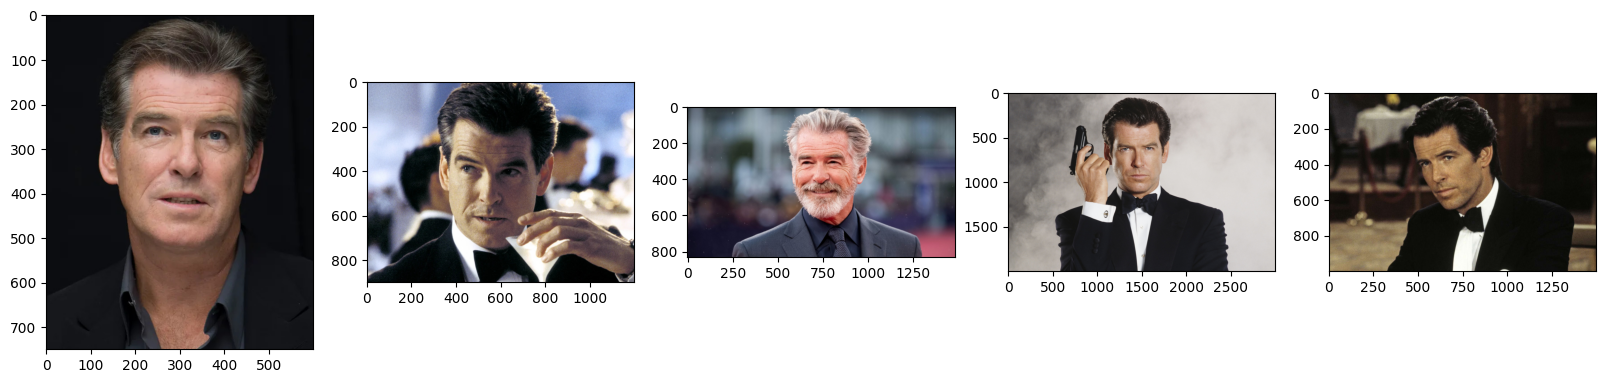

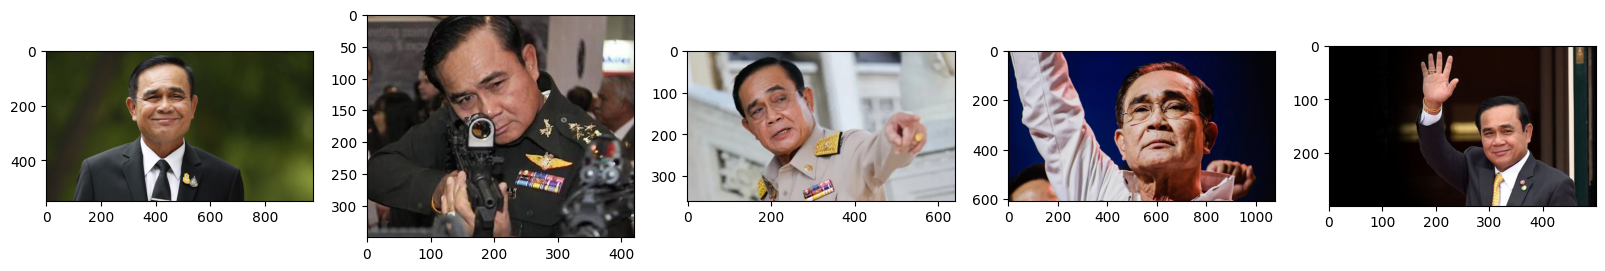

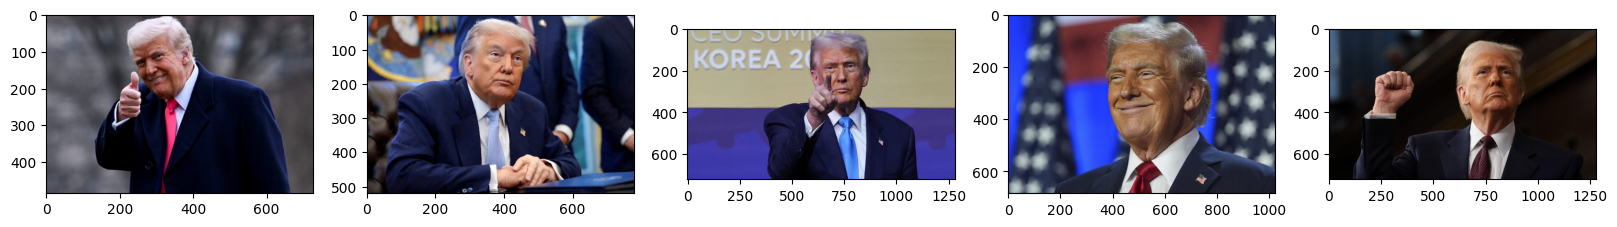

In [5]:
# Example
for i in range(3):
  plt.figure(figsize=(20,20))
  plt.subplot(151)
  plt.imshow(cv2.imread(images[5*i])[...,::-1])
  plt.subplot(152)
  plt.imshow(cv2.imread(images[5*i+1])[...,::-1])
  plt.subplot(153)
  plt.imshow(cv2.imread(images[5*i+2])[...,::-1])
  plt.subplot(154)
  plt.imshow(cv2.imread(images[5*i+3])[...,::-1])
  plt.subplot(155)
  plt.imshow(cv2.imread(images[5*i+4])[...,::-1])

## 2) DeepFace

DeepFace is a lightweight face recognition and facial attribute analysis (age, gender, emotion and race) framework for python. It is a hybrid face recognition framework wrapping state-of-the-art models.

In this lab, we will experiment with three functions of DeepFace:

- Embeddings: `represent` function returns a list of embeddings. Result is going to be the size of faces appearing in the image path.
- Face Verification: `verify` determines whether two facial images belong to the same person or to different individuals
- Facial Attribute Analysis: `analyze` also comes with a facial attribute analysis module including age, gender, facial expression and race predictions.

In [6]:
database = {
    "brosnan": [
        "/content/img/brosnan_01.jpg",
        "/content/img/brosnan_02.jpg",
        "/content/img/brosnan_03.jpg",
        "/content/img/brosnan_04.jpg",
        "/content/img/brosnan_05.jpg",
    ],
    "prayut": [
        "/content/img/prayut_01.jpg",
        "/content/img/prayut_02.jpg",
        "/content/img/prayut_03.jpg",
        "/content/img/prayut_04.jpg",
        "/content/img/prayut_05.jpg",
    ],
    "trump": [
        "/content/img/trump_01.jpg",
        "/content/img/trump_02.jpg",
        "/content/img/trump_03.jpg",
        "/content/img/trump_04.jpg",
        "/content/img/trump_05.jpg",
    ],
}

In [7]:
# Embeddings
models = [
    "VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace",
    "DeepID", "ArcFace", "Dlib", "SFace", "GhostFaceNet",
    "Buffalo_L",
]
model_name = models[2]                   # choose model
# store each identity's many embeddings in vector_database dict
vector_database = {}
for identity, images in tqdm.tqdm(database.items()):
    target_embeddings = []
    for image in images:
        emb = DeepFace.represent(
            img_path=image,
            model_name=model_name,                    # choose model
            detector_backend="mtcnn"                  # choose detector fact
        )[0]["embedding"]
        target_embeddings.append(emb)
    vector_database[identity] = target_embeddings

# store all identities' embeddings in single target_identities list
target_identities = []
target_embeddings = []
for identity, embeddings in vector_database.items():
    for embedding in embeddings:
        target_embeddings.append(embedding)
        target_identities.append(identity)

# store corresponding identity for target_identities
image_sources = []
for identity, images in tqdm.tqdm(database.items()):
    for image in images:
        image_sources.append(image.split("/")[-1].split(".")[0])

  0%|          | 0/3 [00:00<?, ?it/s]

26-01-15 08:23:53 - 🔗 facenet512_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5 to /root/.deepface/weights/facenet512_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5

  0%|          | 0.00/95.0M [00:00<?, ?B/s]
 12%|█▏        | 11.0M/95.0M [00:00<00:00, 93.9MB/s]
 29%|██▉       | 27.8M/95.0M [00:00<00:00, 134MB/s] 
 45%|████▍     | 42.5M/95.0M [00:00<00:00, 115MB/s]
 57%|█████▋    | 54.5M/95.0M [00:00<00:00, 83.7MB/s]
 72%|███████▏  | 68.7M/95.0M [00:00<00:00, 98.5MB/s]
100%|██████████| 95.0M/95.0M [00:00<00:00, 103MB/s] 
100%|██████████| 3/3 [00:00<00:00, 39077.37it/s]


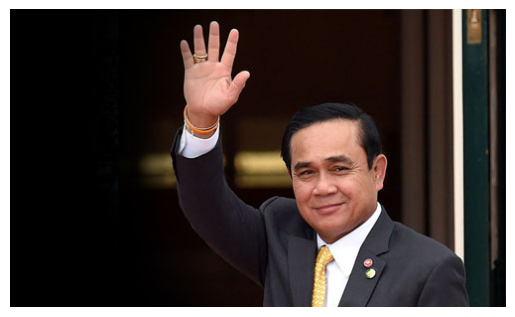

In [18]:
# Show image
img = mpimg.imread(database["prayut"][4])
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

In [11]:
# embedding vector
print(f"embedding len: {len(embedding)}")
print(embedding)

embedding len: 512
[1.6526964902877808, 1.0965301990509033, 1.8078064918518066, 0.12550930678844452, -1.5757787227630615, 1.791746735572815, -1.2586820125579834, 0.9466489553451538, -1.1088489294052124, -0.6858112812042236, 0.7843571901321411, -0.7884135842323303, -0.39962756633758545, -0.23269400000572205, -0.10347320139408112, -0.8754993081092834, -0.9110571146011353, -0.33142074942588806, -1.4701303243637085, -1.3508195877075195, 0.7572353482246399, -2.1938388347625732, 0.33533844351768494, 0.5708057880401611, 0.17603865265846252, -0.062337297946214676, 1.270889163017273, 0.7050267457962036, -1.4347102642059326, 0.02008107304573059, 1.4472103118896484, -0.7083690762519836, -0.37998148798942566, 1.6671561002731323, -0.9345827698707581, 1.2818509340286255, 0.9670219421386719, 0.0006465353071689606, 0.25308331847190857, -1.7455835342407227, 0.25647541880607605, 1.087748408317566, 1.3534173965454102, -0.2504144310951233, 2.5558526515960693, 1.5307263135910034, -1.2624356746673584, -1.71

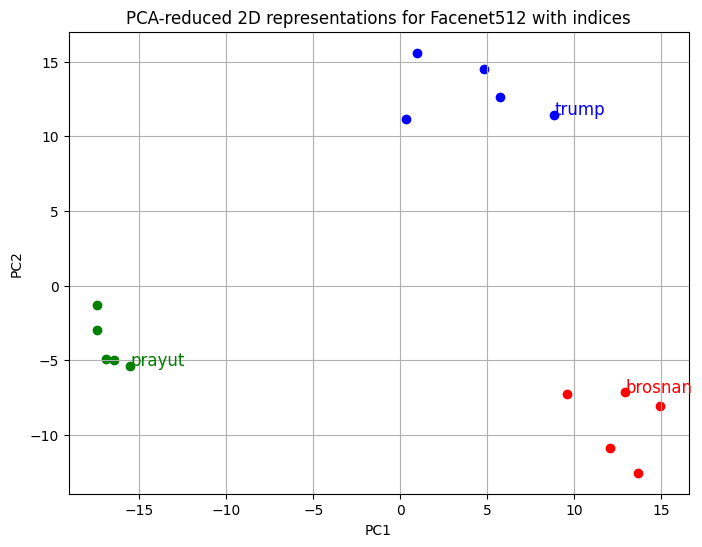

In [12]:
# To simplify visualization, we apply PCA to project the features into 2D space
# Where images of the same person in the dataset are clustered closely together.
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(target_embeddings)
x, y = zip(*vectors_2d)

printed_labels = set()
colors = ['red', 'green', 'blue']

plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(vectors_2d):
    target_identity = target_identities[i]

    target_idx = None
    for idx, (identity, _) in enumerate(database.items()):
        if target_identity == identity:
            target_idx = idx

    plt.scatter(x, y, color=colors[target_idx])

    # plt.text(x + 0.02, y + 0.02, image_sources[i], fontsize=12, color=colors[target_idx])
    if target_identity not in printed_labels:
        plt.text(x + 0.02, y + 0.02, target_identity, fontsize=12, color=colors[target_idx])
        printed_labels.add(target_identity)

plt.title(f"PCA-reduced 2D representations for {model_name} with indices")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

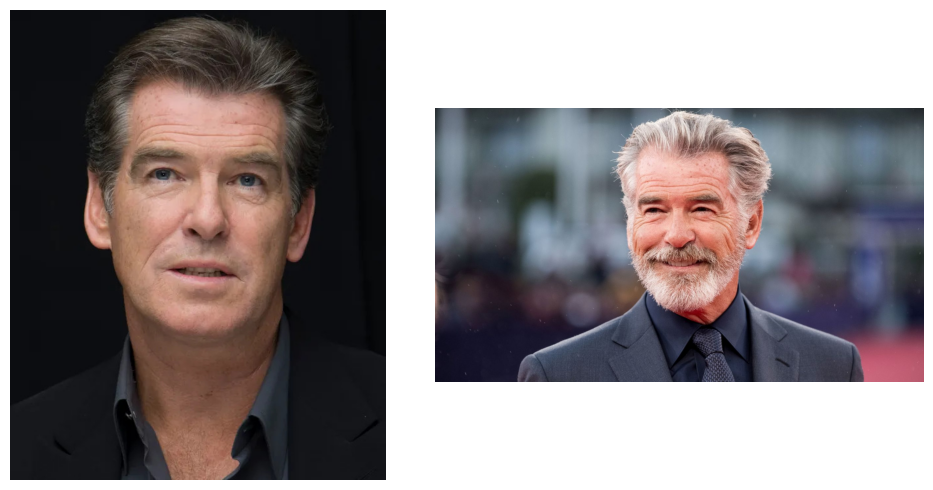

In [20]:
img1 = mpimg.imread(database["brosnan"][0])
img2 = mpimg.imread(database["brosnan"][2])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1)
axes[0].axis("off")
axes[1].imshow(img2)
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Verify
metrics = ["cosine", "euclidean", "euclidean_l2", "angular"]
result = DeepFace.verify(database["brosnan"][0],database["brosnan"][2], distance_metric = metrics[0] ,model_name = models[2])
result

{'verified': True,
 'distance': 0.266768,
 'threshold': 0.3,
 'confidence': 57.27,
 'model': 'Facenet512',
 'detector_backend': 'opencv',
 'similarity_metric': 'cosine',
 'facial_areas': {'img1': {'x': 115,
   'y': 113,
   'w': 396,
   'h': 396,
   'left_eye': (378, 273),
   'right_eye': (241, 262)},
  'img2': {'x': 508,
   'y': 122,
   'w': 475,
   'h': 475,
   'left_eye': None,
   'right_eye': None}},
 'time': 2.71}

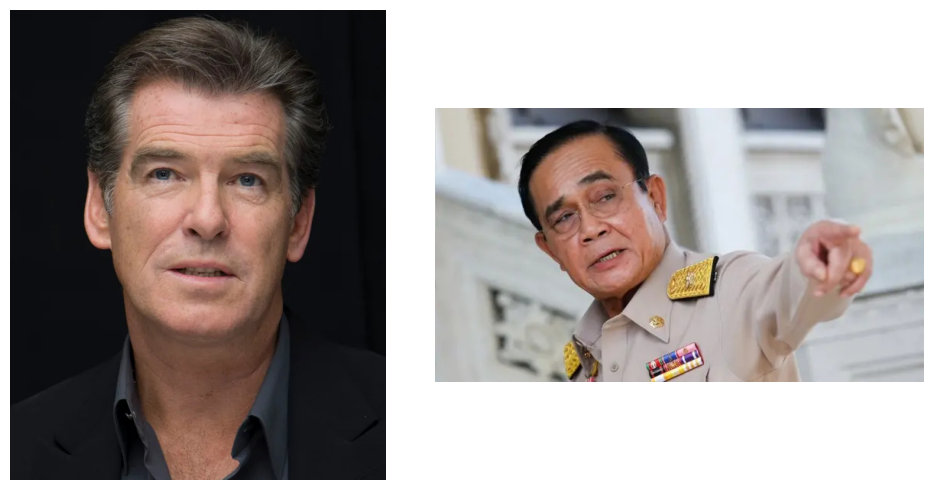

In [21]:
img1 = mpimg.imread(database["brosnan"][0])
img2 = mpimg.imread(database["prayut"][2])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1)
axes[0].axis("off")
axes[1].imshow(img2)
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [14]:
# Verify
metrics = ["cosine", "euclidean", "euclidean_l2", "angular"]
result = DeepFace.verify(database["brosnan"][0],database["prayut"][0], distance_metric = metrics[0] ,model_name = models[2])
result

{'verified': False,
 'distance': 0.921485,
 'threshold': 0.3,
 'confidence': 3.87,
 'model': 'Facenet512',
 'detector_backend': 'opencv',
 'similarity_metric': 'cosine',
 'facial_areas': {'img1': {'x': 115,
   'y': 113,
   'w': 396,
   'h': 396,
   'left_eye': (378, 273),
   'right_eye': (241, 262)},
  'img2': {'x': 304,
   'y': 65,
   'w': 258,
   'h': 258,
   'left_eye': None,
   'right_eye': None}},
 'time': 1.03}

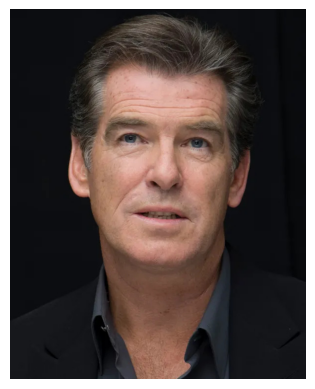

In [19]:
# Show image
img = mpimg.imread(database["brosnan"][0])
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

In [15]:
# Analyze
obj = DeepFace.analyze(img_path = database["brosnan"][0], actions = ['age', 'gender', 'race', 'emotion'])
obj

Action: age:   0%|          | 0/4 [00:00<?, ?it/s]    

26-01-15 08:32:12 - 🔗 age_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5 to /root/.deepface/weights/age_model_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5

  0%|          | 0.00/539M [00:00<?, ?B/s]
  2%|▏         | 11.0M/539M [00:00<00:05, 92.9MB/s]
  4%|▍         | 20.4M/539M [00:00<00:05, 91.7MB/s]
  6%|▌         | 31.5M/539M [00:00<00:05, 99.3MB/s]
  8%|▊         | 42.5M/539M [00:00<00:05, 92.5MB/s]
 11%|█         | 58.2M/539M [00:00<00:04, 113MB/s] 
 13%|█▎        | 70.3M/539M [00:00<00:05, 92.4MB/s]
 15%|█▍        | 80.2M/539M [00:00<00:05, 80.8MB/s]
 18%|█▊        | 94.9M/539M [00:01<00:05, 84.9MB/s]
 21%|██        | 112M/539M [00:01<00:04, 105MB/s]  
 23%|██▎       | 124M/539M [00:01<00:03, 107MB/s]
 25%|██▌       | 135M/539M [00:01<00:03, 108MB/s]
 27%|██▋       | 147M/539M [00:01<00:03, 102MB/s]
 30%|███       | 163M/539M [00:01<00:03, 116MB/s]
 33%|███▎      | 178M/539M [00:01<00:02, 124MB/s]
 35%|███▌      | 191M/539M [00:01<00:02, 116MB/s]
 38%|███▊      | 204M/539M [00

26-01-15 08:32:26 - 🔗 gender_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5 to /root/.deepface/weights/gender_model_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5

  0%|          | 0.00/537M [00:00<?, ?B/s]
  2%|▏         | 11.0M/537M [00:00<00:05, 90.9MB/s]
  6%|▌         | 29.9M/537M [00:00<00:03, 143MB/s] 
  8%|▊         | 45.1M/537M [00:00<00:04, 123MB/s]
 11%|█         | 58.2M/537M [00:00<00:03, 125MB/s]
 13%|█▎        | 71.3M/537M [00:00<00:03, 122MB/s]
 16%|█▌        | 83.9M/537M [00:00<00:03, 119MB/s]
 18%|█▊        | 97.5M/537M [00:00<00:03, 124MB/s]
 21%|██▏       | 115M/537M [00:00<00:03, 140MB/s] 
 24%|██▍       | 130M/537M [00:01<00:04, 91.2MB/s]
 26%|██▋       | 142M/537M [00:01<00:04, 96.6MB/s]
 29%|██▉       | 155M/537M [00:01<00:03, 104MB/s] 
 31%|███▏      | 168M/537M [00:01<00:03, 108MB/s]
 34%|███▎      | 180M/537M [00:01<00:03, 108MB/s]
 36%|███▌      | 192M/537M [00:01<00:03, 107MB/s]
 39%|███▉      | 210M/537M [00:01<00:02, 126MB/s]
 42%|████▏     | 223M/537M [0

26-01-15 08:32:35 - 🔗 race_model_single_batch.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5 to /root/.deepface/weights/race_model_single_batch.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5

  0%|          | 0.00/537M [00:00<?, ?B/s]
  2%|▏         | 11.0M/537M [00:00<00:05, 92.2MB/s]
  4%|▍         | 24.1M/537M [00:00<00:04, 113MB/s] 
  8%|▊         | 42.5M/537M [00:00<00:04, 114MB/s]
 11%|█         | 59.8M/537M [00:00<00:03, 133MB/s]
 14%|█▍        | 73.9M/537M [00:00<00:04, 113MB/s]
 17%|█▋        | 89.7M/537M [00:00<00:03, 125MB/s]
 19%|█▉        | 104M/537M [00:00<00:03, 129MB/s] 
 22%|██▏       | 117M/537M [00:00<00:03, 119MB/s]
 25%|██▌       | 137M/537M [00:01<00:03, 121MB/s]
 28%|██▊       | 149M/537M [00:01<00:03, 116MB/s]
 31%|███       | 164M/537M [00:01<00:03, 124MB/s]
 33%|███▎      | 179M/537M [00:01<00:03, 118MB/s]
 36%|███▋      | 196M/537M [00:01<00:02, 130MB/s]
 39%|███▉      | 210M/537M [00:01<00:02, 120MB/s]
 42%|████▏     | 228M/537M [00:01<00:02, 133MB/s]
 45%|████▍     | 242M/537M 

26-01-15 08:32:41 - 🔗 facial_expression_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5 to /root/.deepface/weights/facial_expression_model_weights.h5...



100%|██████████| 5.98M/5.98M [00:00<00:00, 113MB/s]
Action: emotion: 100%|██████████| 4/4 [00:29<00:00,  7.37s/it]


[{'age': 45,
  'region': {'x': 115,
   'y': 113,
   'w': 396,
   'h': 396,
   'left_eye': (378, 273),
   'right_eye': (241, 262)},
  'face_confidence': 0.9,
  'gender': {'Woman': np.float32(0.47135082), 'Man': np.float32(99.528656)},
  'dominant_gender': 'Man',
  'race': {'asian': np.float32(0.0056317816),
   'indian': np.float32(0.0003178974),
   'black': np.float32(3.2617309e-06),
   'white': np.float32(99.27343),
   'middle eastern': np.float32(0.34461755),
   'latino hispanic': np.float32(0.3760022)},
  'dominant_race': 'white',
  'emotion': {'angry': np.float32(11.738707),
   'disgust': np.float32(0.002389708),
   'fear': np.float32(5.2961206),
   'happy': np.float32(0.823493),
   'sad': np.float32(22.521772),
   'surprise': np.float32(0.091061),
   'neutral': np.float32(59.526455)},
  'dominant_emotion': 'neutral'}]

## 3) Mediapipe



In [22]:
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

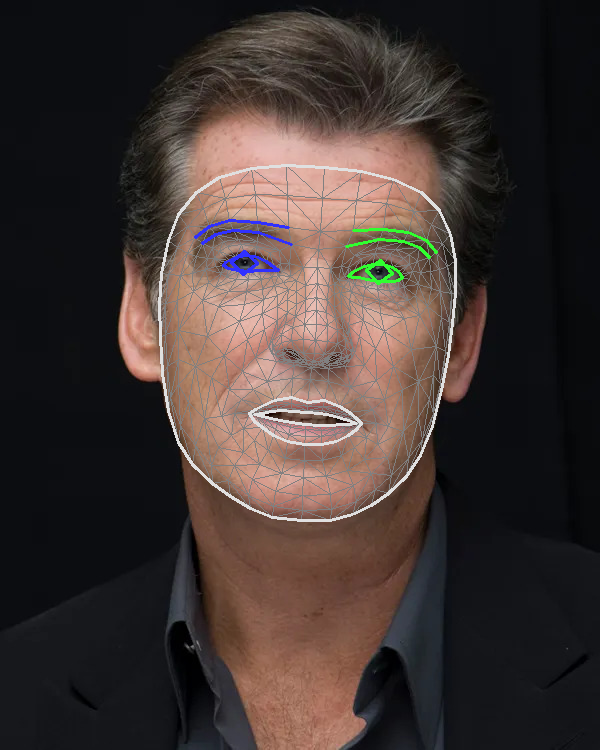

In [23]:
# Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# Load the input image.
image = mp.Image.create_from_file(database["brosnan"][0])

# Detect face landmarks from the input image.
detection_result = detector.detect(image)

# Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [24]:
# The output includes the positions of facial landmarks along with their corresponding indices, where specific indices represent important facial features,
# such as index 50 corresponding to the left nose sneer (noseSneerLeft).
print(f"n point: {len(detection_result.face_landmarks[0])}")
print(detection_result)

n point: 478
FaceLandmarkerResult(face_landmarks=[[NormalizedLandmark(x=0.5131750702857971, y=0.5360471606254578, z=-0.06546761840581894, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5240123271942139, y=0.4718107581138611, z=-0.12005513906478882, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5195852518081665, y=0.4899480938911438, z=-0.06446729600429535, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5093705058097839, y=0.41538047790527344, z=-0.0895523652434349, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5257068872451782, y=0.4540112018585205, z=-0.1270769089460373, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5268973112106323, y=0.4320065677165985, z=-0.1176047995686531, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.52910977602005, y=0.377748042345047, z=-0.056358855217695236, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.38021478056907654, y=0.3573436141014099, z=0.025702549144625664, visibility=0.0, presence=0.0), Normaliz

In [25]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

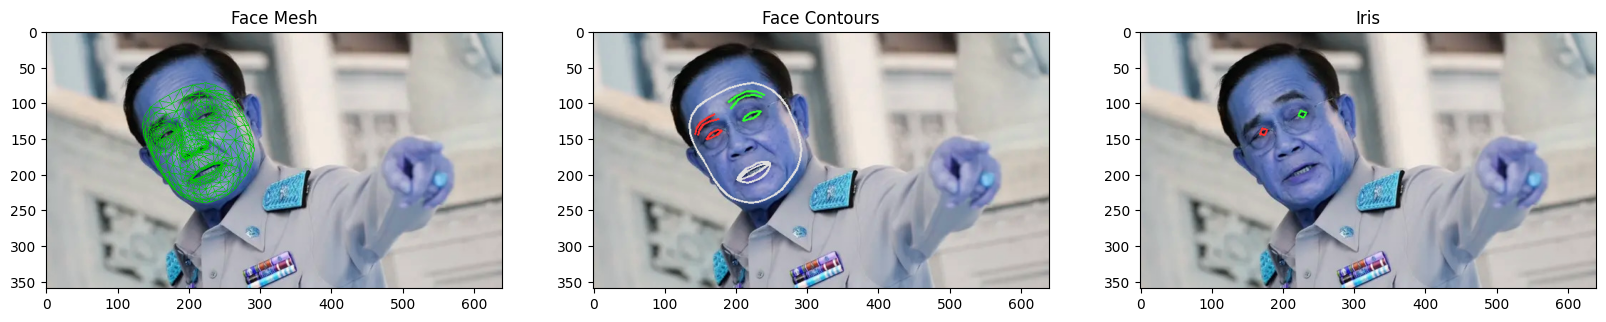

In [28]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing_styles = mp.solutions.drawing_styles

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,
                                  max_num_faces=1,
                                  refine_landmarks=True,
                                  min_detection_confidence=0.5)


# Convert the BGR image to RGB before processing.
rgb_img = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb_img)

# Draw face mesh landmarks on the image.
img_mesh = img2.copy()
img_contours = img2.copy()
img_iris = img2.copy()


for face_landmarks in results.multi_face_landmarks:
    # Mesh.
    mp_drawing.draw_landmarks(img_mesh,
                              face_landmarks,
                              mp_face_mesh.FACEMESH_TESSELATION,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 200, 0), thickness=1, circle_radius=1))
    # Contours.
    mp_drawing.draw_landmarks(img_contours,
                              face_landmarks,
                              mp_face_mesh.FACEMESH_CONTOURS,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
    # Iris.
    mp_drawing.draw_landmarks(img_iris,
                              face_landmarks,
                              mp_face_mesh.FACEMESH_IRISES,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style())

# Display
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img_mesh[...,::-1])
plt.title('Face Mesh');
plt.subplot(132)
plt.imshow(img_contours[...,::-1])
plt.title('Face Contours');
plt.subplot(133)
plt.imshow(img_iris[...,::-1])
plt.title('Iris');